## La divisione di genere degli amministratori locali.
E' un'analisi, basata sugli open data Openpolis, di come siano distribuite sul territorio le differenze di genere nelle giunte e nei consigli municipali.

Si considera come *indicatore di genere*, la percentuale di donne facenti parte dell'organizzazione (giunta o consiglio), rispetto al numero totale di membri.

I dati sono analizzati in relazione alla loro distribuzione geografica, e incrociati, quando possibile con degli indicatori di contesto geografico, demografico e statistico-economico.

Si cercano eventuali correlazioni dell'indicatore con dati di contesto (es: reddito, indice di urbanizzazione, scolarizzazione, ...).

I dati analizzati riguardano gli amministratori locali in carica nelle amministrazioni locali italiane, ad ottobre 2018.

### Setup
In una prima fase, si preparano i dati, letti dalla fonte, che riportano l'elenco di tutti gli incarichi correnti, filtrandoli e trasformandoli in modo da rendere le successive analisi più dirette.

In [1]:
from datetime import timedelta
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from IPython.display import FileLink

I dati sono letti a partire da un file CSV che rappresenta la vista delle membership *flattate* e *arricchite* nel DB OPDM (`view_memberships`).

In [2]:
df = pd.read_csv(
    'dati/all_memberships.csv', 
    dtype=object,
    na_values=['',],
    parse_dates=['birth_date_dt', 'start_date_dt']
)

Il campo `birth_date_dt` è trasformato in un campo di tipo `date`.
Sono prima convertiti dei valori nulli, in modo da evitare problemi successivi. 

In [3]:
df.loc[df.birth_date.isnull(), ('birth_date_dt', )] = np.NaN
df.birth_date_dt = pd.to_datetime(df.birth_date_dt)

Le membership sono filtrate per `role`, 
in questa prima analisi sono considerati i **consiglieri comunali**.

In [4]:
df_genders_stacked = df.loc[df.role.str.contains("Consigliere comunale"), ['area', 'area_istat_com_code', 'gender']]
df_genders_stacked.head()

,area,area_istat_com_code,gender
0,Abano Terme,28001,F
1,Abano Terme,28001,F
2,Abano Terme,28001,M
3,Abano Terme,28001,F
4,Abano Terme,28001,M


I dati sono raggruppati, in modo che le colonne F ed M siano associate al codice di un'area.
Le colonne sono ricostruite a partire dal dataframe multiindex, i valori nulli sono trasformati in None, per evitare che i valori delle colonne F ed M siano trasformati in float.

In [5]:
df_genders_area = df_genders_stacked.groupby(['area_istat_com_code', 'gender']).count().unstack()
df_genders_area.columns = df_genders_area.columns.get_level_values(1)
df_genders_area.columns.name = None
df_genders_area = df_genders_area.where((pd.notnull(df_genders_area)), None)
df_genders_area.head()

,F,M
area_istat_com_code,,
0,18,50
100001,3,9
100002,4,12
100003,7,10
100004,6,6


Sono aggiunte le colonne calcolate `tot` e `perc_f`.

In [6]:
df_genders_area['tot'] = df_genders_area.F + df_genders_area.M
df_genders_area['perc_f'] = 100. * df_genders_area.F / df_genders_area.tot
df_genders_area.head()

,F,M,tot,perc_f
area_istat_com_code,,,,
0,18,50,68,26.4706
100001,3,9,12,25
100002,4,12,16,25
100003,7,10,17,41.1765
100004,6,6,12,50


Si procede a un merge con i nomi delle aree, i loro codici provincia, regione e ripartizione. E' aggiunto l'id OPDM dell'area e dell'istituzione (Organization). 

In [7]:
df_areas = df[df.institution_type=='Consiglio comunale'][[
    'area', 'area_id', 'area_com_code', 'area_istat_com_code', 'area_prov_code', 'area_istat_prov_code', 'area_istat_reg_code', 'area_rip_code',
    'institution_id'
]].drop_duplicates().set_index('area_istat_com_code')
df_genders_area = pd.merge(df_areas, df_genders_area, on='area_istat_com_code', how='right')
df_genders_area.head()

,area,area_id,area_com_code,area_prov_code,area_istat_prov_code,area_istat_reg_code,area_rip_code,institution_id,F,M,tot,perc_f
area_istat_com_code,,,,,,,,,,,,
28001,Abano Terme,3499,A001,PD,28,5,2,42682,7,9,16,43.75
98001,Abbadia Cerreto,2673,A004,LO,98,3,1,47970,4,6,10,40
97001,Abbadia Lariana,2588,A005,LC,97,3,1,37914,3,9,12,25
52001,Abbadia San Salvatore,4635,A006,SI,52,9,3,48096,4,8,12,33.3333
95001,Abbasanta,7761,A007,OR,95,20,5,46264,5,4,9,55.5556


### Identificazione dei record problematici
Sono rimossi i casi errati e particolari. 

Abbiamo visto come in alcuni casi il campo `area_istat_com_code` sia zero. Questo è indice di un problema nella fonte dati, quindi i record sono scritti in un CSV, per analisi ulteriori.

In [8]:
df_zero_istat_code_com = df[df.area_istat_com_code=='0'][['area', 'area_com_code']].drop_duplicates()
df_zero_istat_code_com.to_csv("dati/zero_istat_code_com_councils.csv")
FileLink("dati/zero_istat_code_com_councils.csv")

/Users/gu/Workspace/jupyter-notebooks/opdm/dati/zero_istat_code_com_councils.csv

Il numero di consiglieri comunali non può mai essere minore di 8.
Di seguito viene identificato l'elenco dei consigli comunali comuni con meno di 7 consiglieri, per poi essere rimosso dal set di dati considerati per l'analisi.

In [9]:
df_wrong_councils = df_genders_area[df_genders_area.tot < 7]
df_wrong_councils[['area', 'area_id', 'institution_id', 'tot']].to_csv("dati/few_counselors.csv")
FileLink("dati/few_counselors.csv")

/Users/gu/Workspace/jupyter-notebooks/opdm/dati/few_counselors.csv

### Estrazione dati su campione valido

Sul campione di dati ritenuto valido, vengono estratti i **top 10** e i **bottom 10, rispetto alla percentuale di donne elette, e le medie a livello provinciale, regionale e di ripartizione geografica.

In [10]:
df_good = df_genders_area[
    ~(df_genders_area.area_com_code.isin(df_zero_istat_code_com.area_com_code)) &
    (df_genders_area.tot >= 7)
]

# conversione di alcune colonne
df_good.loc[:, 'perc_f'] = df_good.perc_f.astype(float).fillna(0.0);
df_good.loc[:, 'area_istat_reg_code'] = df_good.area_istat_reg_code.astype(int);
df_good.loc[:, 'area_istat_com_code'] = df_good.index.astype(int);

/Users/gu/Workspace/jupyter-notebooks/venv/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/gu/Workspace/jupyter-notebooks/venv/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/gu/Workspace/jupyter-notebooks/venv/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [12]:
df_good.sort_values(by='perc_f', ascending=False).head(10)

,area,area_id,area_com_code,area_prov_code,area_istat_prov_code,area_istat_reg_code,area_rip_code,institution_id,F,M,tot,perc_f,area_istat_com_code
area_istat_com_code,,,,,,,,,,,,,
18099,Monticelli Pavese,2313,F670,PV,18,3,1,37738,7,2,9,77.777778,18099
91071,Ovodda,7722,G201,NU,91,20,5,35706,6,2,8,75.000000,91071
37050,Sala Bolognese,4323,H678,BO,37,8,2,36140,9,3,12,75.000000,37050
3044,Cavaglietto,424,C364,NO,3,1,1,36574,7,3,10,70.000000,3044
83063,Oliveri,7356,G036,ME,83,19,5,46876,7,3,10,70.000000,83063
2115,Rive,375,H346,VC,2,1,1,39530,7,3,10,70.000000,2115
33048,Ziano Piacentino,4144,L848,PC,33,8,2,41642,7,3,10,70.000000,33048
20009,Carbonara di Po,2529,B739,MN,20,3,1,48634,7,3,10,70.000000,20009
33015,Cerignale,4113,C513,PC,33,8,2,43206,7,3,10,70.000000,33015


In [13]:
df_good.sort_values(by='perc_f').head(10)

,area,area_id,area_com_code,area_prov_code,area_istat_prov_code,area_istat_reg_code,area_rip_code,institution_id,F,M,tot,perc_f,area_istat_com_code
area_istat_com_code,,,,,,,,,,,,,
71024,Foggia,6418,D643,FG,71,16,4,36334,1,31,32,3.125000,71024
87002,Aci Castello,7488,A026,CT,87,19,5,48286,1,17,18,5.555556,87002
74003,Ceglie Messapica,6528,C424,BR,74,16,4,37096,1,16,17,5.882353,74003
60033,Ferentino,5345,D539,FR,60,12,3,36340,1,16,17,5.882353,60033
1059,Carmagnola,59,B791,TO,1,1,1,44248,1,15,16,6.250000,1059
22117,Mezzolombardo,2985,F187,TN,22,4,2,37966,1,15,16,6.250000,22117
63008,Boscoreale,6034,B076,NaN,63,15,4,39256,1,15,16,6.250000,63008
21044,Luson/Lüsen,2831,E764,BZ,21,4,2,43762,1,14,15,6.666667,21044
58009,Ariccia,5167,A401,RM,58,12,3,42312,1,13,14,7.142857,58009


A partire dal dataset corretto, sono prodotti dei files CSV con le medie per provincia, regione e ripartizione.
I files possono essere scaricati e sono usati in seguito per le analisi.

In [14]:
medie_province = df_good.groupby(['area_prov_code', 'area_istat_prov_code'])['perc_f'].mean().sort_values(ascending=False)
medie_province.to_csv('dati/genere_medie_province.csv', header=True)
FileLink("dati/genere_medie_province.csv")

/Users/gu/Workspace/jupyter-notebooks/opdm/dati/genere_medie_province.csv

In [15]:
medie_regioni = df_good.groupby('area_istat_reg_code')['perc_f'].mean().sort_values(ascending=False)
medie_regioni.to_csv('dati/genere_medie_regioni.csv', header=True)
FileLink("dati/genere_medie_regioni.csv")

/Users/gu/Workspace/jupyter-notebooks/opdm/dati/genere_medie_regioni.csv

In [16]:
medie_rip = df_good.groupby('area_rip_code')['perc_f'].mean().sort_values(ascending=False)
medie_rip.to_csv('dati/genere_medie_ripartizioni.csv', header=True)
FileLink("dati/genere_medie_ripartizioni.csv")

/Users/gu/Workspace/jupyter-notebooks/opdm/dati/genere_medie_ripartizioni.csv

### Analisi dati

Il primo risultato interessante, perché inaspettato, è la predominanza della regione Sicilia e di tutte le sue province, nella classifica dei territori con la maggior percentuale di donne nei consigli comunali. Si può notare questo dato nelle mappe.

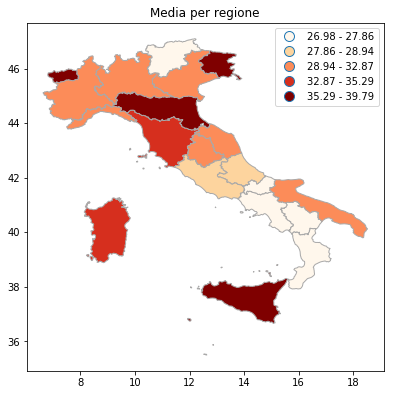

In [62]:
# caricamento dati CSV e topojson delle province
geo_df = gpd.read_file('../geojson/regioni.topo.json')
geo_df.crs = {'init' :'epsg:4326'}
data_df = pd.read_csv('dati/genere_medie_regioni.csv', encoding='utf8')

# fusione dei dataframe geografici e csv
df=geo_df.merge(data_df, left_on='cod_reg', right_on='area_istat_reg_code', how='right').fillna(0)

# rimozione colonne inutili e cambio nome
df.drop(columns=['id', 'area_istat_reg_code'], inplace=True)

# plot
reg_plot = df.plot(
    column='perc_f', cmap='OrRd', scheme='Fisher_Jenks', 
    legend=True, figsize=[6.4, 6.4],
    edgecolor='darkgray',
)
reg_plot.set_title('Media per regione');

In [18]:
data_df.head()

,area_istat_reg_code,perc_f
0,19,39.789723
1,2,38.222405
2,6,37.355993
3,8,37.238583
4,9,35.286136


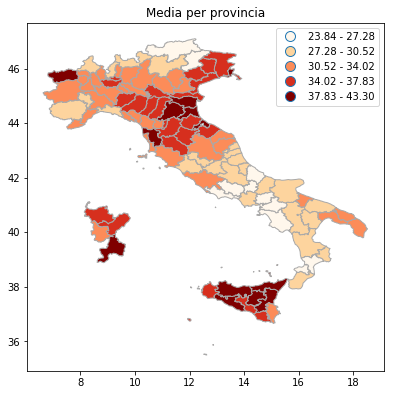

In [19]:
# caricamento dati CSV e topojson delle regioni
geo_df = gpd.read_file('../geojson/province.topo.json')
geo_df.crs = {'init' :'epsg:4326'}
data_df = pd.read_csv('dati/genere_medie_province.csv', encoding='utf8')

# fusione dei dataframe geografici e csv
df=geo_df.merge(data_df, left_on='cod_pro', right_on='area_istat_prov_code', how='right').fillna(0)

# rimozione colonne inutili e cambio nome
df.drop(columns=['id', 'area_istat_prov_code'], inplace=True)
df.rename(columns={'area_prov_code': 'prov'}, inplace=True)

# plot
prov_plot = df.plot(
    column='perc_f', cmap='OrRd', scheme='Fisher_Jenks', 
    legend=True, figsize=[6.4, 6.4],
    edgecolor='darkgray',
)
prov_plot.set_title('Media per provincia');

---

#### Nota
E' possibile ottenere i limiti topojson, a partire dai dati dei territori (progetto `oc_territori`), 
attraverso l'uso di mapshaper, seguendo queste semplici istruzioni:

```bash
    # extrazine geojson di tutti i comuni dal DB
    python manage.py get_geojson -v2 \
    --file-name resources/data/oc_comuni.geo.json

    # pulizia, semplificazione, export in topojson
    mapshaper\
        -i resources/data/oc_comuni.geo.json -clean \
            encoding=utf8 \
        -simplify 5% weighted \
        -o resources/data/oc_comuni.simplified.topo.json bbox format=topojson

    # generazione ed export layers regioni, province e comuni
    mapshaper \
      -i resources/data/oc_comuni.simplified.topo.json \
      -rename-layers comuni \
      -dissolve cod_pro + copy-fields=cod_reg name=province \
      -target comuni -dissolve cod_reg + name=regioni \
      -o ../jupyter-notebooks/geojson/comuni.topo.json bbox target=comuni format=topojson  \
      -o ../jupyter-notebooks/geojson/province.topo.json bbox target=province format=topojson \
      -o ../jupyter-notebooks/geojson/regioni.topo.json bbox target=regioni format=topojson
```

---

Si può approfondire la situazione della regione Sicilia, a livello comunale, per capire se si tratta di spikes isolati o di distribuzioni uniformi.

In [37]:
# filtro sui topojson comunali, per la regione Sicilia
geo_df = gpd.read_file('../geojson/comuni.topo.json')
geo_df = geo_df[geo_df.cod_reg==19]

# filtro sui dati disaggregati per la regione Sicilia
data_df = df_good[df_good.area_istat_reg_code==19]

# fusione dei dataframe geografici e csv
df = geo_df.merge(data_df, left_on='cod_com', right_on='area_istat_com_code', how='right').fillna(0)

# rimozione colonne inutili e cambio nome
df.drop(columns=['id', 'area_istat_reg_code'], inplace=True)
df.rename(columns={'area_prov_code': 'prov'}, inplace=True);

Sono molti i comuni con dati mancanti (75 su 390), ma per il resto sono molti i comuni con medie elevate e la distribuzione è *skewed* verso valori alti dell'indicatore, grazie all'elevato numero (80) di comuni con percentuali tra il 40% e il 50%.

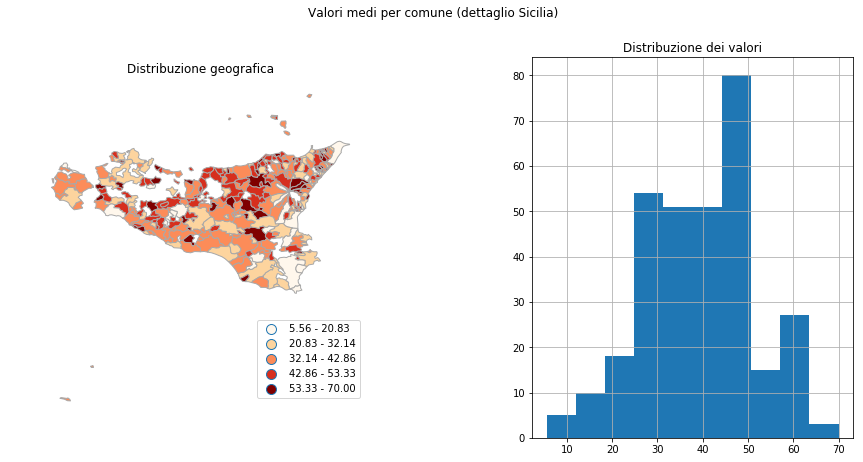

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(7. * 2.1, 7.))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('Valori medi per comune (dettaglio Sicilia)')

axes = axes.flatten()

ax = df.plot(
    column='perc_f', ax=axes.flat[0], cmap='OrRd', scheme='Fisher_Jenks', 
    legend=True,
    edgecolor='darkgray',
)
ax.set_aspect('equal')
ax.set_axis_off()
ax.set_title('Distribuzione geografica')
leg = ax.get_legend()
leg.set_bbox_to_anchor((0., 0., 1., 0.3))

ax = df.perc_f.hist(axes=axes.flat[1])
ax.set_aspect('equal')
ax.set_title('Distribuzione dei valori');


Questo l'elenco dei 10 comuni con percentuale maggiore in Sicilia.

In [22]:
data_df.sort_values('perc_f', ascending=False).head(10)

,area,area_id,area_com_code,area_prov_code,area_istat_prov_code,area_istat_reg_code,area_rip_code,institution_id,F,M,tot,perc_f,area_istat_com_code
area_istat_com_code,,,,,,,,,,,,,
83063,Oliveri,7356,G036,ME,83,19,5,46876,7,3,10,70.000000,83063
83094,Scaletta Zanclea,7387,I492,ME,83,19,5,44130,6,3,9,66.666667,83094
83108,Torrenova,7401,M286,ME,83,19,5,38320,7,4,11,63.636364,83108
83035,Gualtieri Sicaminò,7328,E233,ME,83,19,5,42994,5,3,8,62.500000,83035
87046,Sant'Alfio,7532,I216,CT,87,19,5,51124,5,3,8,62.500000,87046
83050,Militello Rosmarino,7343,F210,ME,83,19,5,42960,5,3,8,62.500000,83050
86006,Catenanuova,7472,C353,EN,86,19,5,49390,5,3,8,62.500000,86006
83070,Reitano,7363,H228,ME,83,19,5,45292,5,3,8,62.500000,83070
83017,Cesarò,7310,C568,ME,83,19,5,44912,5,3,8,62.500000,83017


## Correlazione con i redditi
Si cerca una correlazione con la distribuzione del reddito nelle famiglie.

I dati sul reddito 2016 (dichiarazioni 2017) sono disponibili sul sito del MEF: http://www1.finanze.gov.it/finanze3/analisi_stat/index.php?search_class[0]=cCOMUNE&opendata=yes

In [23]:
# lettura dati da file scaricato
redd_df = pd.read_csv(
    'dati/redditi_irpef_2016.csv',
    sep=';', encoding='utf8'
)

In [47]:
# filtro su sole colonne interessanti
data_df = redd_df[['Codice catastale', 'Codice Istat Comune',
       'Denominazione Comune', 'Sigla Provincia', 'Regione',
       'Codice Istat Regione', 'Numero contribuenti','Reddito imponibile - Frequenza',
       'Reddito imponibile - Ammontare in euro',
       'Reddito complessivo da 0 a 10000 euro - Frequenza',
       'Reddito complessivo da 0 a 10000 euro - Ammontare in euro',            
       'Reddito complessivo oltre 120000 euro - Frequenza',
       'Reddito complessivo oltre 120000 euro - Ammontare in euro']]

# colonne rinominate
data_df.rename(columns={
    'Codice catastale': 'com_code', 
    'Codice Istat Comune': 'istat_com_code',
    'Denominazione Comune': 'comune', 
    'Sigla Provincia': 'prov', 
    'Regione': 'reg',
    'Codice Istat Regione': 'istat_reg_code', 
    'Numero contribuenti': 'num_contribuenti',
    'Reddito complessivo da 0 a 10000 euro - Frequenza': 'freq_10k-',
    'Reddito complessivo da 0 a 10000 euro - Ammontare in euro': 'redd_10k-',            
    'Reddito complessivo oltre 120000 euro - Frequenza': 'freq_120k+',
    'Reddito complessivo oltre 120000 euro - Ammontare in euro': 'redd_120k+',
    'Reddito imponibile - Frequenza': 'imponibile_freq',
    'Reddito imponibile - Ammontare in euro': 'imponibile_euro',
}, inplace=True)

# calcolo percentuali e valori medi per abitante e contribuente
data_df.loc[:, 'perc_freq'] = data_df.imponibile_freq / data_df.num_contribuenti
data_df.loc[:, 'perc_freq_10k-'] = data_df['freq_10k-'] / data_df.num_contribuenti
data_df.loc[:, 'perc_freq_120k+'] = data_df['freq_120k+'] / data_df.num_contribuenti

data_df.loc[:, 'imponibile_per_ab'] = data_df.imponibile_euro / data_df.num_contribuenti
data_df.loc[:, 'imponibile_per_contr'] = data_df.imponibile_euro / data_df.imponibile_freq

data_df.fillna(0, inplace=True)
data_df.sort_values(by='imponibile_per_ab', ascending=False).head(10)

,com_code,istat_com_code,comune,prov,reg,istat_reg_code,num_contribuenti,imponibile_freq,imponibile_euro,freq_10k-,redd_10k-,freq_120k+,redd_120k+,perc_freq,perc_freq_10k-,perc_freq_120k+,imponibile_per_ab,imponibile_per_contr
3410,E413,50016,LAJATICO,PI,Toscana,9,1002,971,45483352,291,1594877,0.0,0.0,0.969062,0.290419,0.000000,45392.566866,46841.763131
565,A699,15015,BASIGLIO,MI,Lombardia,3,5339,5038,230292291,1069,4432060,367.0,91636183.0,0.943622,0.200225,0.068739,43133.974714,45711.054188
2500,D229,15097,CUSAGO,MI,Lombardia,3,2857,2726,109630272,491,2143025,141.0,36636161.0,0.954148,0.171859,0.049352,38372.513826,40216.534116
7146,L269,18159,TORRE D'ISOLA,PV,Lombardia,3,1724,1664,57447075,270,1241630,64.0,12001051.0,0.965197,0.156613,0.037123,33321.969258,34523.482572
5183,G678,1192,PINO TORINESE,TO,Piemonte,1,6140,5843,202773575,1274,5996012,237.0,53173683.0,0.951629,0.207492,0.038599,33025.012215,34703.675338
6247,I090,1250,SAN PIETRO VAL LEMINA,TO,Piemonte,1,1114,1070,36201449,237,1125018,28.0,13274622.0,0.960503,0.212747,0.025135,32496.812388,33833.129907
6617,I577,15205,SEGRATE,MI,Lombardia,3,25433,24493,822331811,5031,23355969,859.0,205089627.0,0.963040,0.197814,0.033775,32333.260370,33574.156330
4961,G398,1183,PECETTO TORINESE,TO,Piemonte,1,2887,2727,91675087,589,2709456,108.0,24550133.0,0.944579,0.204018,0.037409,31754.446484,33617.560323
320,A389,15009,ARESE,MI,Lombardia,3,14095,13525,446115919,2545,11528820,396.0,90536679.0,0.959560,0.180560,0.028095,31650.650514,32984.541146
7480,L704,108046,VEDANO AL LAMBRO,MB,Lombardia,3,5526,5301,174420616,1135,5096030,166.0,44229605.0,0.959283,0.205393,0.030040,31563.629388,32903.342011


In [48]:
df = df_good.merge(
    data_df[['com_code', 'imponibile_per_ab', 'imponibile_per_contr', 'perc_freq_10k-', 'perc_freq_120k+']],
    left_on='area_com_code', right_on='com_code', how='right'
)
df.drop(columns=['com_code', 'institution_id', 'F', 'M', 'tot'], inplace=True)
df.fillna(0., inplace=True)
df.loc[:, 'area_istat_com_code'] = df.area_istat_com_code.astype(int);
df.loc[:, 'area_istat_reg_code'] = df.area_istat_reg_code.astype(int);

In [49]:
df.head()

,area,area_id,area_com_code,area_prov_code,area_istat_prov_code,area_istat_reg_code,area_rip_code,perc_f,area_istat_com_code,imponibile_per_ab,imponibile_per_contr,perc_freq_10k-,perc_freq_120k+
0,Abano Terme,3499,A001,PD,28,5,2,43.750000,28001,22260.693101,23103.042134,0.225915,0.011008
1,Abbadia Cerreto,2673,A004,LO,98,3,1,40.000000,98001,16824.585366,17687.384615,0.273171,0.000000
2,Abbadia Lariana,2588,A005,LC,97,3,1,25.000000,97001,22599.035608,23310.505028,0.208139,0.010598
3,Abbadia San Salvatore,4635,A006,SI,52,9,3,33.333333,52001,16343.366988,16822.230396,0.281589,0.002867
4,Abbasanta,7761,A007,OR,95,20,5,55.555556,95001,17317.455294,17940.081658,0.308235,0.000000


Analiziamo la correlazione, mostrando i grafici dei valori della percentuale e di alcune delle variabili di reddito.

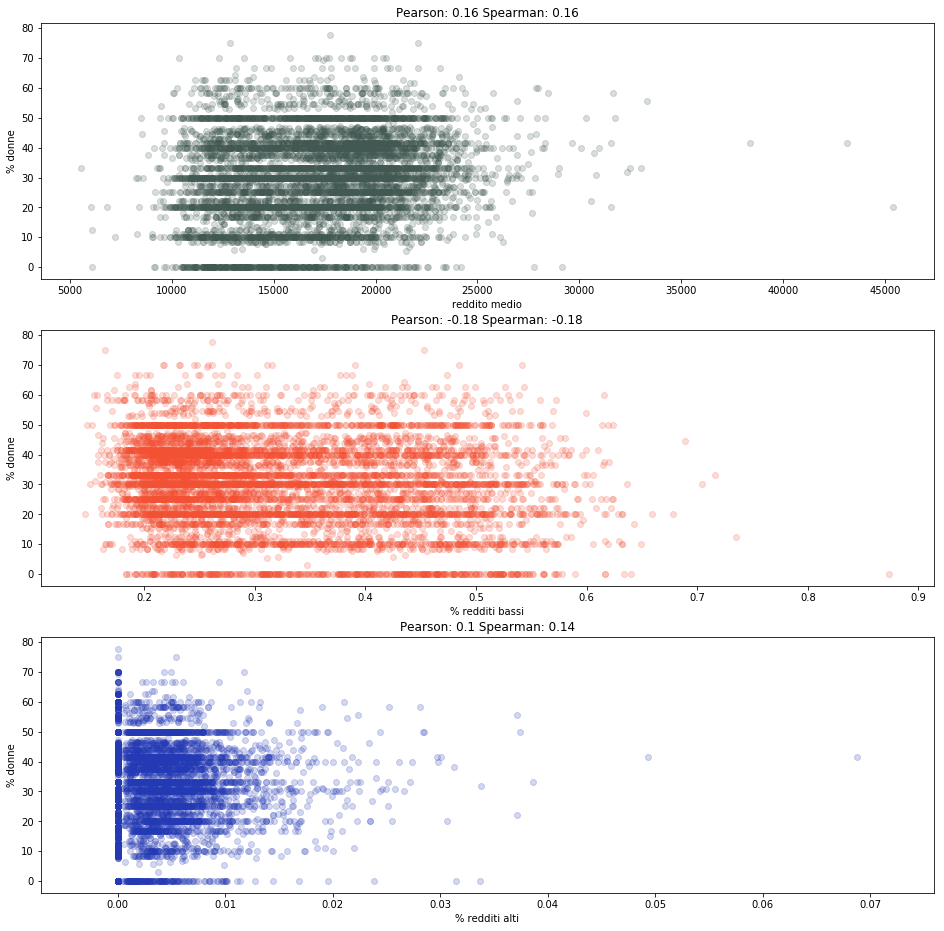

In [61]:
plt.rcParams['figure.figsize'] = [16, 16]

fig, ax = plt.subplots(nrows=3, ncols=1)

ax=ax.flatten()
config = [
    {
        'column': 'imponibile_per_ab', 
        'label': 'reddito medio',
        'color': '#415952'
    },
    {
        'column': 'perc_freq_10k-', 
        'label': '% redditi bassi',
        'color': '#f35134'
    },
    {
        'column': 'perc_freq_120k+', 
        'label': '% redditi alti',
        'color': '#243AB5'
    }
]

for j, i in enumerate(ax):
    i.set_ylabel('% donne')
    i.scatter(df[config[j]['column']], df['perc_f'], alpha=0.2, color=config[j]['color'])
    i.set_xlabel(config[j]['label'])
    i.set_title(
        'Pearson: %s' % df.corr().loc[config[j]['column']]['perc_f'].round(2) + 
        ' Spearman: %s' % df.corr(method='spearman').loc[config[j]['column']]['perc_f'].round(2)
    )


    
    


E' quindi possibile dire che **c'è pochissima correlazione tra la percentuale di donne e il reddito medio**.

Anche la correlazione (inversa) tra la percentuale di redditi bassi e il numero di donne è molto bassa.

Ancora più bassa è la correlazione tra redditi alti e numero di donne.